# Mounting to drive

In [452]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [453]:
!pip install tensorflow

In [454]:
!pip install fasttext

In [455]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input, Flatten, MaxPooling1D, SpatialDropout1D, Activation

from keras.callbacks import EarlyStopping

from numpy import array
from sklearn.metrics import classification_report

import gensim
from gensim import models
from gensim.models import Word2Vec
import fasttext.util
import pandas as pd
import numpy as np

# Loading Model

In [456]:
fasttext_model = fasttext.load_model("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/fasttext/model_bn_300.bin")

# Load Dataset

In [457]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/train.csv")
val_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/dev.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/test.csv")

In [458]:
print(f'train: {train_dataset.shape}\nval: {val_dataset.shape}\ntest: {test_dataset.shape}')

train: (2700, 2)
val: (1330, 2)
test: (2016, 2)


# Oversampling

In [459]:
train_dataset['label'].value_counts()

0    1389
1     922
2     389
Name: label, dtype: int64

In [460]:
# # Find the maximum class frequency
# max_class_frequency = train_dataset['label'].value_counts().max()

# # Group the dataset by labels
# grouped = train_dataset.groupby('label')

# resampled_data = []
# for label, group in grouped:
#     if len(group) < max_class_frequency:
#         oversampled_group = group.sample(max_class_frequency, replace=True, random_state=42)
#         resampled_data.append(oversampled_group)
#     else:
#         resampled_data.append(group)

# # Concatenate the resampled groups to create the balanced dataset
# balanced_dataset = pd.concat(resampled_data)

# # Shuffle the dataset to ensure randomness
# balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [461]:
# grouped.head()

In [462]:
# balanced_dataset.shape

In [463]:
# balanced_dataset['label'].value_counts()

In [464]:
# train_dataset = balanced_dataset
# train_dataset['label'].value_counts()

In [465]:
train_x = train_dataset['text']
train_y = train_dataset['label']

val_x = val_dataset['text']
val_y = val_dataset['label']

test_x = test_dataset['text']
test_y = test_dataset['label']

# Embedding Setup

In [466]:
tokenizer=Tokenizer(oov_token = "<OOV>", split=' ') # Splitting text based on whitespace and adding "Out of vocabulary"
tokenizer.fit_on_texts(train_x) # Using the tokenizer on out train dataset to tokenize the train dataset
train_encoded=tokenizer.texts_to_sequences(train_x)
# print(train_encoded)


[[15, 85, 3670, 105, 3671, 85, 519, 304, 159, 248], [4, 7, 312, 7, 3672, 7, 8, 75, 3673, 1220, 115, 3674, 3675, 3676, 8], [1460, 3677, 1053, 95, 42, 16, 762, 2374, 36, 3, 275, 39, 47, 650, 48, 13, 42, 16, 36, 3, 848, 46], [1221, 1222, 63], [153, 24, 1223, 1461, 154, 2375, 385, 33, 571, 3678, 47, 99, 1462, 3679, 58, 520], [521, 29, 27, 96, 763, 47, 1816, 14, 135, 99, 77, 3680, 10, 3681, 3682, 599], [121, 399, 2376, 1224, 127, 4, 24, 226, 106, 12, 80, 7, 236], [3683, 2377, 195, 123, 97, 318, 123, 1054, 123, 3684, 123, 136, 123, 495, 123], [145, 16, 258, 95, 41, 64, 3685, 12, 522, 243, 81, 600, 2378], [62, 41], [3686, 496, 1817, 3687, 1463], [3688, 330, 249, 36, 43, 3689, 3690, 140, 73], [182, 521, 523, 2379, 1464, 3691, 36, 276], [764, 164, 2380, 942, 3692, 3693, 4, 497, 17, 345, 63, 1818, 23, 268, 362, 173, 2381, 10, 2382, 1055], [420, 289, 331, 9, 46, 3694, 2383, 313, 227, 332, 165, 333, 3, 712, 524, 314, 3, 51, 2384, 202, 1819, 3695, 173, 331, 420, 289], [183, 136, 318, 183, 136], [65

In [467]:
train_padded= pad_sequences(train_encoded, padding='post', maxlen=256)
# print(train_padded)

[[   15    85  3670 ...     0     0     0]
 [    4     7   312 ...     0     0     0]
 [ 1460  3677  1053 ...     0     0     0]
 ...
 [  556  1022   410 ...     0     0     0]
 [    4   624   666 ...     0     0     0]
 [ 3404 10169   594 ...     0     0     0]]


In [468]:
train_padded.shape[1]

256

In [469]:
# padding df_test
test_encoded=tokenizer.texts_to_sequences(test_x)
test_padded= pad_sequences(test_encoded, padding='post', maxlen=train_padded.shape[1])

In [470]:
# padding df_validation
val_encoded=tokenizer.texts_to_sequences(val_x)
val_padded= pad_sequences(val_encoded, padding='post', maxlen=train_padded.shape[1])

In [471]:
# function that takes word vector as input and returned an embedding layer
def embedding_creation(EMBEDDING_DIM, word_vectors):
  vocabulary_size=len(tokenizer.word_index)+1
  word_index=tokenizer.word_index
  embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

  for word, i in word_index.items():
    try:
      embedding_vector=word_vectors[word] # taking the word vector of all the words in the index
      embedding_matrix[i]=embedding_vector # inserting the vector of the word to the embeddings matrix,  index wise
    except KeyError:
      embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
      """
      The strategy of generating random vectors for missing words (KeyError)
      in the embedding matrix is useful because it provides a way to
      include out-of-vocabulary words in the representation,
        prevents loss of information, helps with stable training, and
        ensures a complete embedding matrix for neural network models.
      """
  embedding_layer=Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)

  return embedding_layer

In [472]:
EMBEDDING_DIM = 300
wv = fasttext_model
IFT = embedding_creation(EMBEDDING_DIM, wv)
# gets the embedding layer from the word vectors using EMBEDDING_DIM as dim size

In [473]:
max_length = train_padded.shape[1]
vocabulary_size = len(tokenizer.word_index) + 1
# creating a randomly initialized embedding layer (RE)
RE = Embedding(vocabulary_size, EMBEDDING_DIM,input_length = max_length, trainable=True)

# Early Stopping

In [474]:
earlystop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [475]:
emb_X_name_collection = [ [IFT, 'IFT']]
"""
IFT = embedding_creation(EMBEDDING_DIM, wv)
# IFT has the embedding layer from the word vectors using EMBEDDING_DIM as dim size
"""

'\nIFT = embedding_creation(EMBEDDING_DIM, wv)\n# IFT has the embedding layer from the word vectors using EMBEDDING_DIM as dim size\n'

# Model Configuration Original

In [476]:
!pip install keras

In [477]:
from tensorflow.keras.layers import Layer, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K


In [478]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [479]:
# num_classes = 3
# # Loop through each embedding layer and create models with attention
# for emb_X_name in emb_X_name_collection:
#     model = Sequential([
#         emb_X_name[0],
#         Bidirectional(LSTM(150, dropout=0.3, return_sequences=True)),
#         attention(),
#         Dense(32, activation='relu'),
#         Dense(num_classes, activation='softmax'),  # Use softmax for multi-class classification
#     ],
#     name="Sentiment_Model")
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [480]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

num_classes = 3
learning_rate = 0.001  # Adjust the learning rate as needed

for emb_X_name in emb_X_name_collection:
    model = Sequential([
        emb_X_name[0],
        Bidirectional(LSTM(150, dropout=0.3, return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax'),  # Use softmax for multi-class classification
    ],
    name="Sentiment_Model")

    optimizer = Adam(learning_rate=learning_rate)  # Set the learning rate for the optimizer

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [481]:
# !pip install pydot graphviz
# import pydot
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='bilstm_model.png', show_shapes=True)
# from IPython.display import Image
# Image('bilstm_model.png')

# Training

In [482]:
history = model.fit(train_padded, train_y, epochs=100, batch_size=32, validation_data=(val_padded, val_y), callbacks=[earlystop_callback])

Epoch 1/100
85/85 [==============================] - 11s 60ms/step - loss: 0.8601 - accuracy: 0.6170 - val_loss: 0.7113 - val_accuracy: 0.7045
Epoch 2/100
85/85 [==============================] - 4s 44ms/step - loss: 0.6430 - accuracy: 0.7374 - val_loss: 0.6327 - val_accuracy: 0.7301
Epoch 3/100
85/85 [==============================] - 4s 50ms/step - loss: 0.5449 - accuracy: 0.7763 - val_loss: 0.6404 - val_accuracy: 0.7083
Epoch 4/100
85/85 [==============================] - 5s 57ms/step - loss: 0.4969 - accuracy: 0.7978 - val_loss: 0.6337 - val_accuracy: 0.7241
Epoch 5/100
85/85 [==============================] - 4s 49ms/step - loss: 0.4442 - accuracy: 0.8326 - val_loss: 0.6154 - val_accuracy: 0.7331
Epoch 6/100
85/85 [==============================] - 5s 60ms/step - loss: 0.3892 - accuracy: 0.8552 - val_loss: 0.6278 - val_accuracy: 0.7451
Epoch 7/100
85/85 [==============================] - 6s 65ms/step - loss: 0.3382 - accuracy: 0.8652 - val_loss: 0.6405 - val_accuracy: 0.7376
Epoch

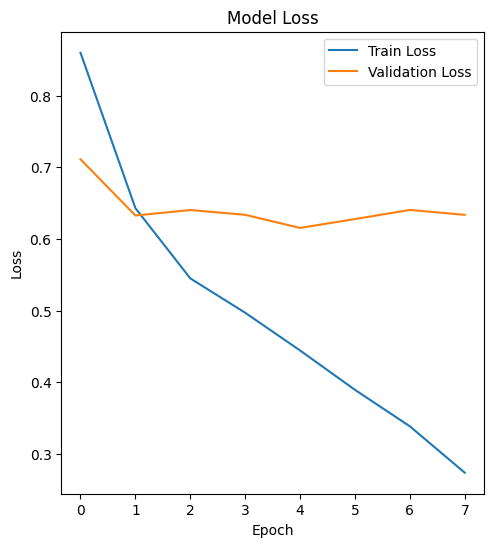

In [483]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']  # Replace with 'acc' if using an older version of TensorFlow/Keras
val_accuracy = history.history['val_accuracy']  # Replace with 'val_acc' for older versions

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



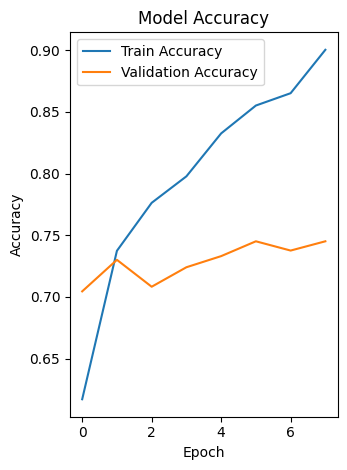

In [484]:

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [485]:
prediction = model.predict(test_padded)

p = []
for i in range(len(prediction)):
    a = []
    for j in range(3):
        a.append(round(prediction[i][j]))
    p.append(a)


63/63 [==============================] - 2s 11ms/step


In [486]:
prediction

array([[0.45817998, 0.4585587 , 0.08326124],
       [0.6228328 , 0.09175864, 0.28540865],
       [0.97456837, 0.0180629 , 0.00736869],
       ...,
       [0.09691254, 0.03638568, 0.8667018 ],
       [0.01163208, 0.08023624, 0.9081316 ],
       [0.9276346 , 0.05654119, 0.01582413]], dtype=float32)

In [487]:
# Determine the maximum column index for each row
max_indices = np.argmax(p, axis=1)

# Create a DataFrame with the max_indices
pred_labels = pd.DataFrame({'Value': max_indices})

In [488]:
pred_labels

,Value
0,0
1,0
2,0
3,1
4,1
...,...
2011,0
2012,1
2013,2
2014,2


In [489]:
from sklearn.metrics import classification_report

target_names = ['neutral', 'passive', 'active']
r = classification_report(test_y, pred_labels, output_dict=True)

In [490]:
r

{'0': {'precision': 0.7696160267111853,
  'recall': 0.8412408759124088,
  'f1-score': 0.8038360941586749,
  'support': 1096},
 '1': {'precision': 0.7401960784313726,
  'recall': 0.6300417246175244,
  'f1-score': 0.6806912096168295,
  'support': 719},
 '2': {'precision': 0.6213592233009708,
  'recall': 0.6368159203980099,
  'f1-score': 0.628992628992629,
  'support': 201},
 'accuracy': 0.7455357142857143,
 'macro avg': {'precision': 0.7103904428145095,
  'recall': 0.7026995069759812,
  'f1-score': 0.7045066442560444,
  'support': 2016},
 'weighted avg': {'precision': 0.744341939261464,
  'recall': 0.7455357142857144,
  'f1-score': 0.7424845522519476,
  'support': 2016}}

In [491]:
df = pd.DataFrame(r)

# Transpose the DataFrame
df = df.transpose()

print(df)

              precision    recall  f1-score      support
0              0.769616  0.841241  0.803836  1096.000000
1              0.740196  0.630042  0.680691   719.000000
2              0.621359  0.636816  0.628993   201.000000
accuracy       0.745536  0.745536  0.745536     0.745536
macro avg      0.710390  0.702700  0.704507  2016.000000
weighted avg   0.744342  0.745536  0.742485  2016.000000


In [493]:
# model.save("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/bilstm70.h5")  # Save the model in an h5 format